# Drawing

## (1) 盒鬚圖
不同隱藏層神經元數量 (n=[1,20])下的 30 次建模結果盒鬚圖

In [1]:
from module.draw.draw import display_boxplot
name_experiment = "2024_0608_1257_part2"

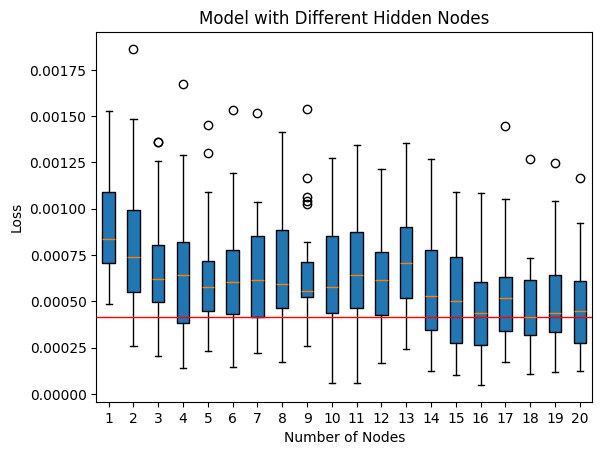

In [2]:
ttl_loss_in = display_boxplot(name_experiment, type_loss=0)
# ttl_loss_in

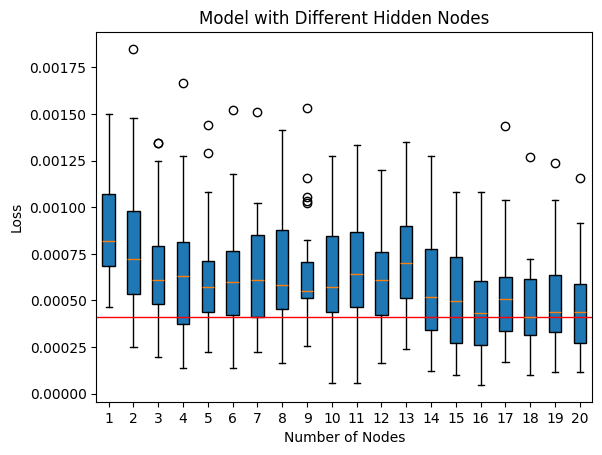

In [3]:
ttl_loss_out = display_boxplot(name_experiment, type_loss=1)
# ttl_loss_out

由上面兩張圖可以看出， <br>
無論是 best in-sample loss 或 best out-of-sample loss， <br>
當 n=18 時，其 loss 的平均、盒子的寬度，皆為最小值。<br>
<br>
故接下來探討 <b>n=1</b> 時的狀況。

## (2) 真實 vs 預測
最佳隱藏層數量下，30 次建模結果最佳解的真實與預測解比較

In [4]:
import numpy as np
from module.for_model.checkpoint import get_best_model
from module.for_dataset.create_dataset import create_dataset
from module.for_dataset.normalization import normalization

### 調出 best model 的 best checkpoint 的參數

In [5]:
name_experiment = "2024_0608_1257_part2"
n = 18
nn_best, _ = get_best_model(name_experiment, n)

### 建立其他沒看過的資料

In [6]:
# 建立其他沒看過的資料
# (之前 random seed 設 0，這次要設不一樣)

random_seed = 1
num_analysis = 20
num_data = int(num_analysis/0.8)

X, Y, _, _ = create_dataset(random_seed, num_data, "sum")

# reshape for the model output
Y = Y.reshape((-1,1))

# normalize
normalizer = normalization(X)
X_n = normalizer.normalize(X)
Y_n = normalizer.normalize(Y)

X_n

array([[0.09994385, 0.87568782],
       [0.32341381, 0.56608647],
       [0.01448624, 0.47276811],
       [0.86872544, 0.38708591],
       [0.60426727, 0.60179674],
       [0.33093768, 0.28085345],
       [0.94654688, 0.39831555],
       [0.5332959 , 0.90713083],
       [0.73295901, 0.06142617],
       [0.91364402, 0.34070747],
       [0.08287479, 0.21033127],
       [0.49410444, 0.32139248],
       [0.4032566 , 0.28590679],
       [1.        , 0.7586749 ],
       [0.04671533, 0.45581134],
       [0.05918024, 0.16428972],
       [0.34620999, 0.20539023],
       [0.29803481, 0.        ],
       [0.25030882, 0.88613139],
       [0.14497473, 0.11577765]])

### 比較不同輸入時，預測值、真實值的差異

In [7]:
# 稍微計算一下 loss
loss_average = nn_best.evaluate(X_n, Y_n)
loss_average

0.00010580254945374804

In [8]:
# 比較輸入、預測值、標籤
diff = np.zeros(num_analysis, dtype=int)
for x, y, idx in zip(X, Y, range(num_analysis)):
    x_n = normalizer.normalize(x)
    pred = nn_best.forward([x_n])[0]
    y_pred = normalizer.unnormalize(pred)
    y_pred = y_pred.round()
    
    diff[idx] = y[0] - y_pred[0]
    print(f"x = {x}, y_pred = {y_pred[0]}, y = {y[0]}")

diff

x = [1905 8813], y_pred = 10711.0, y = 10718
x = [3895 6056], y_pred = 10042.0, y = 9951
x = [1144 5225], y_pred = 6298.0, y = 6369
x = [8751 4462], y_pred = 13284.0, y = 13213
x = [6396 6374], y_pred = 12885.0, y = 12770
x = [3962 3516], y_pred = 7468.0, y = 7478
x = [9444 4562], y_pred = 14029.0, y = 14006
x = [5764 9093], y_pred = 14815.0, y = 14857
x = [7542 1562], y_pred = 9070.0, y = 9104
x = [9151 4049], y_pred = 13253.0, y = 13200
x = [1753 2888], y_pred = 4473.0, y = 4641
x = [5415 3877], y_pred = 9366.0, y = 9292
x = [4606 3561], y_pred = 8191.0, y = 8167
x = [9920 7771], y_pred = 17356.0, y = 17691
x = [1431 5074], y_pred = 6444.0, y = 6505
x = [1542 2478], y_pred = 3813.0, y = 4020
x = [4098 2844], y_pred = 6890.0, y = 6942
x = [3669 1015], y_pred = 4442.0, y = 4684
x = [3244 8906], y_pred = 12172.0, y = 12150
x = [2306 2046], y_pred = 4145.0, y = 4352


array([   7,  -91,   71,  -71, -115,   10,  -23,   42,   34,  -53,  168,
        -74,  -24,  335,   61,  207,   52,  242,  -22,  207])

誤差「比例」雖不大，但「值」差很多，我猜可能 train 的時候可以選擇下面其中一個方式（意義差不多）
1. learning rate 可以調大一點，
2. loss 應該用 unnormalied 的 data 算

## (3) 學習曲線
最佳隱藏層數量下，30 次建模結果最佳解的學習曲線

In [9]:
import numpy as np
from module.for_model.checkpoint import get_best_model, load_checkpoint
import matplotlib.pyplot as plt

#### 調出 best model 的所有 checkpoint

In [10]:
name_experiment = "2024_0608_1257_part2"
n = 18
_, idx_best = get_best_model(name_experiment, n)
idx_best

10

In [11]:
path_folder = f"checkpoints\\{name_experiment}\\node_{n:02d}"
ttl_loss = load_checkpoint(path_folder, "loss")
ttl_loss = np.array(ttl_loss)
ttl_loss.shape

(30, 21, 2)

#### 畫圖

In [12]:
x = range(ttl_loss.shape[1])
y_loss_in = ttl_loss[idx_best,:,0]      # in-sample loss        # 紅色
y_loss_out = ttl_loss[idx_best,:,1]     # out-of-sample loss    # 藍色

##### 觀察整體
看起來學習曲線下降得非常快

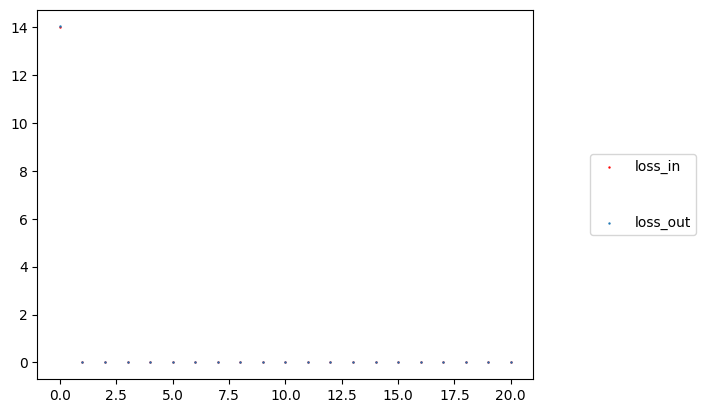

In [13]:
plt.scatter(x, y_loss_in, s=0.5, label="loss_in", color="r")
plt.scatter(x, y_loss_out, s=0.5, label="loss_out")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)

## (4) Error Histogram
最佳隱藏層數量下，30 次建模結果最佳解的 Error Histogram。

In [14]:
import numpy as np
from module.for_model.checkpoint import get_best_model
from module.for_dataset.create_dataset import create_dataset
from module.for_dataset.normalization import normalization
import matplotlib.pyplot as plt

### 調出 best model 的 best checkpoint 的參數

In [15]:
name_experiment = "2024_0608_1257_part2"
n = 16
nn_best, _ = get_best_model(name_experiment, n)

### 建立其他沒看過的資料

In [16]:
# 建立其他沒看過的資料
# (之前 random seed 設 0，這次要設不一樣)

random_seed = 2
num_analysis = 10000
num_data = int(num_analysis/0.8)

X, Y, _, _ = create_dataset(random_seed, num_data, "sum")

# reshape for the model output
Y = Y.reshape((-1,1))

# normalize
normalizer = normalization(X)
X_n = normalizer.normalize(X)
Y_n = normalizer.normalize(Y)

X_n

array([[0.81529229, 0.28617471],
       [0.73760836, 0.27939542],
       [0.12213825, 0.5301178 ],
       ...,
       [0.96010224, 0.78839742],
       [0.73916426, 0.93231829],
       [0.46176928, 0.12991776]])

### 取得 error

In [17]:
# 取得 error
ttl_error = np.zeros(num_analysis, dtype=int)
for x_n, y, idx in zip(X_n, Y, range(num_analysis)):
    pred = nn_best.forward([x_n])
    y_pred = normalizer.unnormalize(pred)
    y_pred = y_pred.round()
    ttl_error[idx] = y[0] - y_pred[0,0]
ttl_error

array([-51, -54,  -6, ..., 150, 148,  34])

(array([829., 857., 905., 866., 892., 762., 805., 767., 783., 863., 801.,
        297.,  96.,  87.,  51.,  61.,  36.,  43.,  38.,  36.,  24.,  20.,
         14.,  15.,  14.,  13.,   7.,   8.,   6.,   4.]),
 array([-128.        , -107.56666667,  -87.13333333,  -66.7       ,
         -46.26666667,  -25.83333333,   -5.4       ,   15.03333333,
          35.46666667,   55.9       ,   76.33333333,   96.76666667,
         117.2       ,  137.63333333,  158.06666667,  178.5       ,
         198.93333333,  219.36666667,  239.8       ,  260.23333333,
         280.66666667,  301.1       ,  321.53333333,  341.96666667,
         362.4       ,  382.83333333,  403.26666667,  423.7       ,
         444.13333333,  464.56666667,  485.        ]),
 <BarContainer object of 30 artists>)

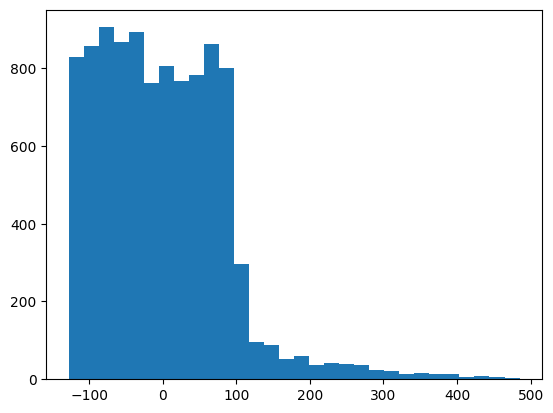

In [18]:
# 畫圖
plt.hist(ttl_error, bins=30)

從長調圖可以看出，大概四成的情況下，預測值都比真實值大